In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random

In [2]:
import layers as custom_layers

In [3]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [5]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = fixedImg.astype('float')
fixedImg = np.expand_dims(fixedImg, axis=0)

def data_generator(batchSize = 1):
    # TODO: Batchify the funciton.
    while True:
        idx = random.randrange(trainDataSize)
        inputObj = np.load(trainDataPath.format(idx))
        movingImg = inputObj['img']
        movingImg = np.expand_dims(movingImg, axis=-1)
        movingImg = movingImg.astype('float')
        movingImg = np.expand_dims(movingImg, axis=0)
        imgPair = np.concatenate([movingImg, fixedImg], axis=4)

        tgtAffineTrf = inputObj['trf']
        tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
        
        
        yield (imgPair, [fixedImg, tgtAffineTrf])

## NN with labels as fixed images

In [6]:
# Get rid of the batch dimension
imgPairShape = list(fixedImg.shape)[1:]
# Change the channel dimension to get the image pair shape
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)
movingImg = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
print(movingImg.shape)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(inputs)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation="relu")(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation="relu")(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(conv_3)
print("conv_4: {}".format(conv_4.shape))
flattened = layers.Flatten()(conv_4)
dense_0 = layers.Dense(1024, activation="relu")(flattened)
dense_1 = layers.Dense(256, activation="relu")(dense_0)
dense_2 = layers.Dense(64, activation="relu")(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)
# rotation_scaling = layers.Dense(9, activation="relu")(dense_0)
# translation = layers.Dense(3, activation="relu")(dense_0)
# '''
# Using tf functions here. Maybe replace them with Keras layer ops?
# '''
# rot_scl_reshaped = tf.reshape(rotation_scaling, (-1, 3, 3))
# trans_reshaped = tf.reshape(translation, (-1, 3, 1))
# affine_pred = layers.Concatenate(axis=-1)([rot_scl_reshaped, trans_reshaped])
# affine_pred = layers.Reshape((12,), name="affine_pred")(affine_pred)
# print(affine_pred.shape)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([movingImg, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

(None, 52, 256, 256, 2)
(None, 52, 256, 256, 1)
conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 42, 98, 98, 8)
filtered_conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
filtered_conv_2: (None, 16, 21, 21, 16)
conv_3: (None, 13, 14, 14, 24)
conv_4: (None, 10, 11, 11, 32)
Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


In [7]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="combined_model")
model.summary()

Model: "combined_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 47, 113, 113, 49156       input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 42, 98, 98, 8 49160       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 21, 49, 49, 8 0           conv3d_1[0][0]                   
_____________________________________________________________________________________

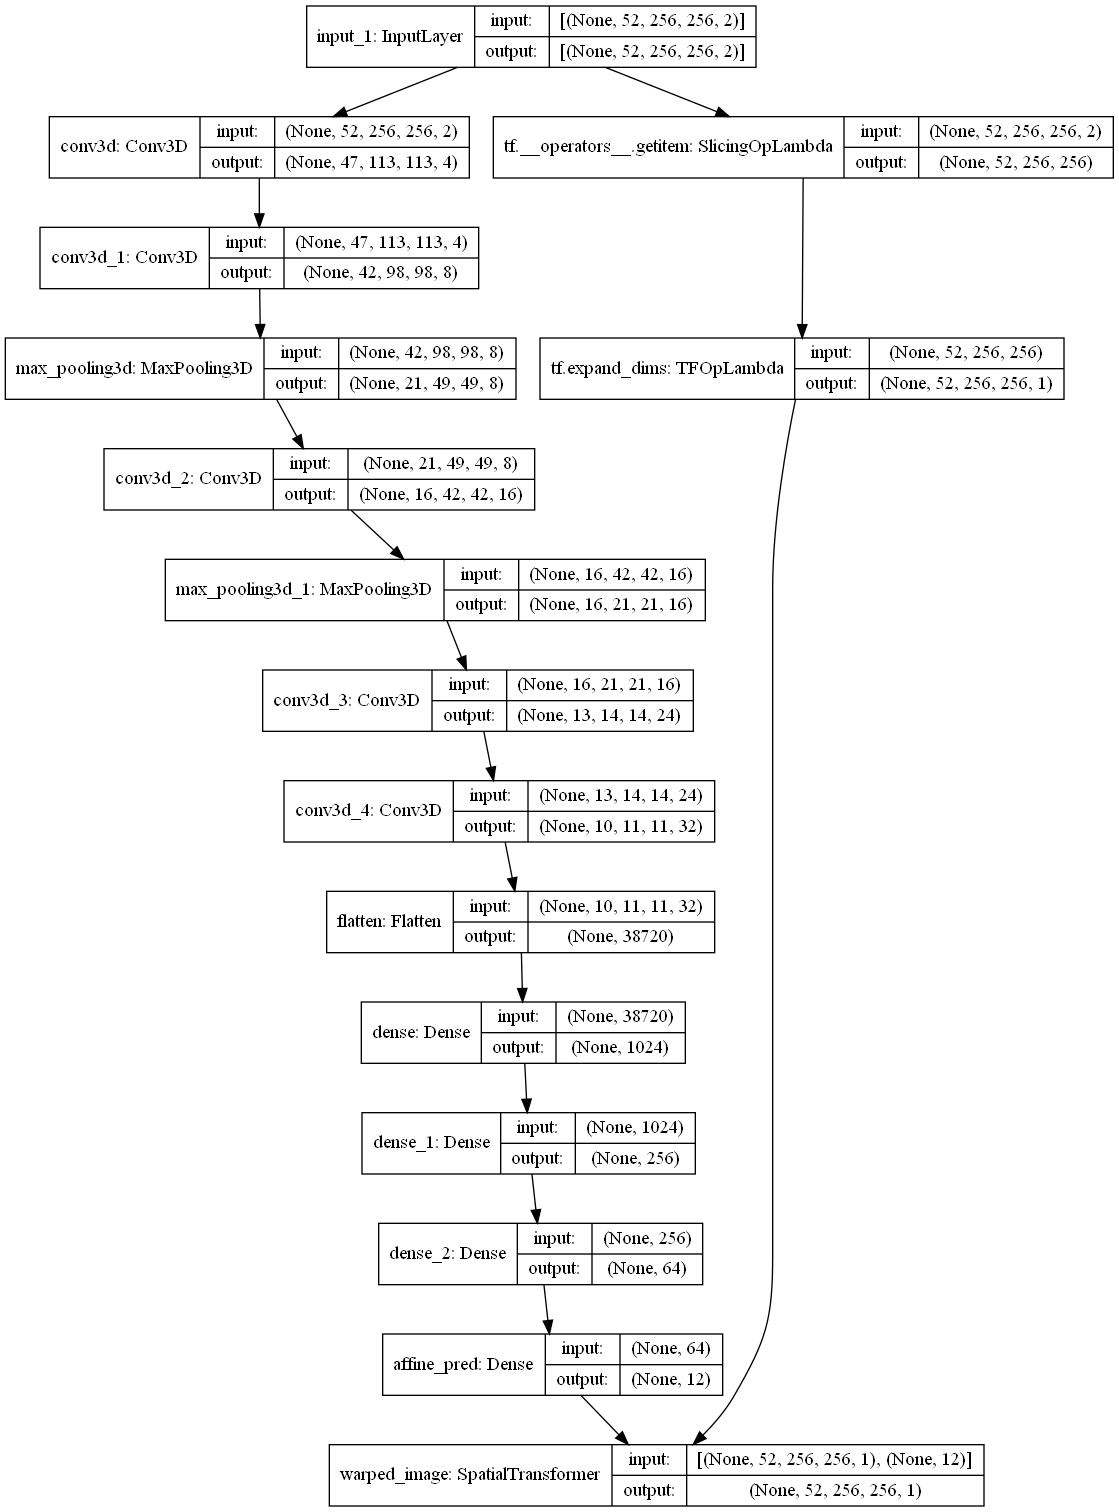

In [8]:
keras.utils.plot_model(model, "test.png", show_shapes=True)

In [9]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
# loss_object = tf.keras.losses.MeanSquaredError()

loss_history = []
save_callback = ModelCheckpoint('./checkpoints/{epoch:02d}.h5')

In [10]:
"""
y = (deformed_img, affine_trf)
"""
def affine_loss(y_actual, y_pred):
    y_actual = y_actual[0]
    y_pred = y_pred[0]
    tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
    predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
    tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
    predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
    tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
    predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
    mse = tf.keras.losses.MeanSquaredError()
    diag_loss = mse(tgtDiag, predDiag)
    corner_loss = mse(tgtCorner, predCorner)
    translation_loss = mse(tgtTranslation, predTranslation)
    return corner_loss * 100 + diag_loss * 10 + translation_loss

In [11]:
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":affine_loss},
              loss_weights={"warped_image":1, "affine_pred":1},
              run_eagerly=True)

In [12]:
dataGen = data_generator()

In [13]:
model.fit(dataGen, epochs=20, steps_per_epoch=trainDataSize, callbacks=[save_callback])

Epoch 1/20
2000/2000 [==============================] - 1081s 537ms/step - loss: 133096083.3387 - warped_image_loss: 7506.4086 - affine_pred_loss: 133087891.6605
Epoch 2/20
2000/2000 [==============================] - 1068s 534ms/step - loss: 7506.7939 - warped_image_loss: 7498.3238 - affine_pred_loss: 8.4669
Epoch 3/20
2000/2000 [==============================] - 1071s 535ms/step - loss: 7509.9419 - warped_image_loss: 7501.5493 - affine_pred_loss: 8.3834
Epoch 4/20
2000/2000 [==============================] - 1070s 535ms/step - loss: 7509.4439 - warped_image_loss: 7501.2690 - affine_pred_loss: 8.1761
Epoch 5/20
2000/2000 [==============================] - 1066s 533ms/step - loss: 7509.5792 - warped_image_loss: 7501.2418 - affine_pred_loss: 8.3394
Epoch 6/20
2000/2000 [==============================] - 1071s 535ms/step - loss: 7509.0556 - warped_image_loss: 7500.8595 - affine_pred_loss: 8.1955
Epoch 7/20
2000/2000 [==============================] - 1069s 534ms/step - loss: 7508.9194 - 

## Test model (output == warpedImg)

In [14]:
testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])

In [15]:
# testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
testModel.load_weights('./checkpoints/20.h5')

In [19]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(affine_pred_test)

[[ 9.74657634e-01  6.36712195e-03  8.41443590e-03 -2.14625361e+00
  -5.77733410e-03  9.17095680e-01 -2.47595040e-02 -7.78768720e+00
  -8.72988596e-03  2.66995804e-02  9.90993408e-01 -5.41088224e+00]]
tf.Tensor(
[[ 0.9869009  -1.385579   -0.9388627  -1.4568672   0.16495775  0.3188155
   0.2589388  -4.5880117   0.9024665   0.5071575   0.5446274  -4.821051  ]], shape=(1, 12), dtype=float32)


In [ ]:
print(warped_test.shape)
print(type(moving_test))
print(np.sum(warped_test))

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()